# **Assignment 01**
## Md Adib Hossain
## 24V0034

###**Import** all essential libraries

In [94]:
import numpy as np #to deal with arrays and related operations
import pandas as pd #to convert csv file to dataframe
import matplotlib.pyplot as plt #to get plot graphs
import seaborn as sns #to get additional plot features
import sqlite3 #to summarize the data by ZIP code
from IPython.display import display #to display all dataframe of a cell
import sqlite3  #for creating a database
import statsmodels.api as sm  #for statistical models
import os
import kagglehub #for downloading dataset from kaggle
from sklearn.cluster import DBSCAN, KMeans #for clustering
from sklearn.manifold import TSNE #for t-SNE visualization
from sklearn.decomposition import PCA #for PCA
from sklearn.preprocessing import StandardScaler



### **Question 01:** Data preprocessing

####Import and Load the Dataset


In [95]:
#download the dataset
path = kagglehub.dataset_download("alirezachahardoli/customer-data-clustring")

#load the dataset
data = pd.read_csv(os.path.join(path, "Customer-Data - 2.csv"))
#display basic information and the first few rows of the dataset
print(data.info())
print(data.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

#### a. Visualize and pre-process the data using a power, an exponential, or a log transformation.


Visualizing distributions of numeric columns:


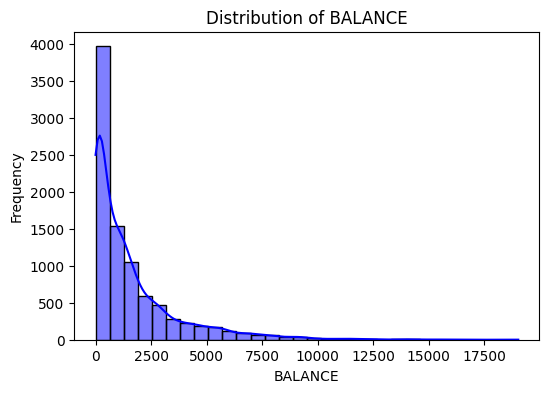

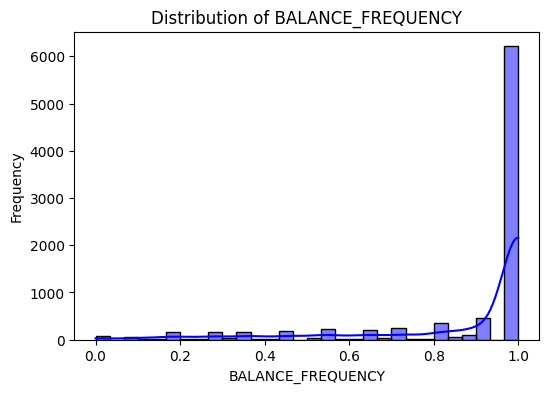

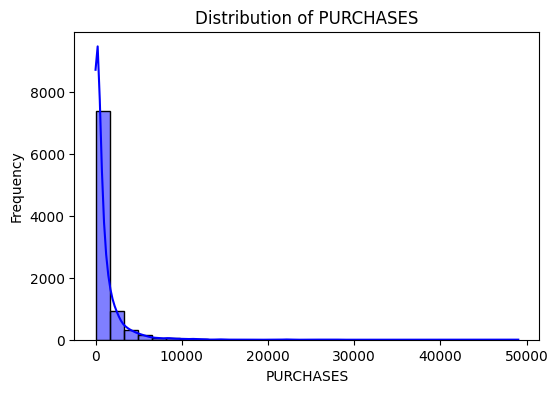

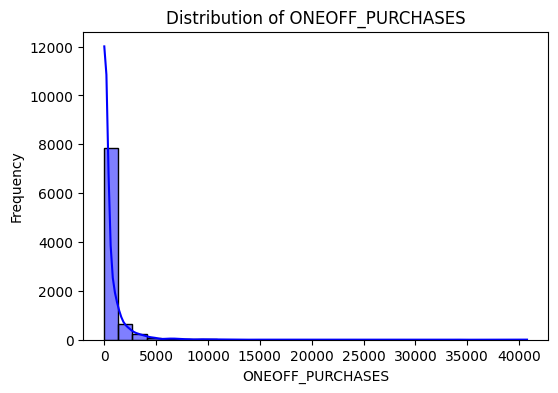

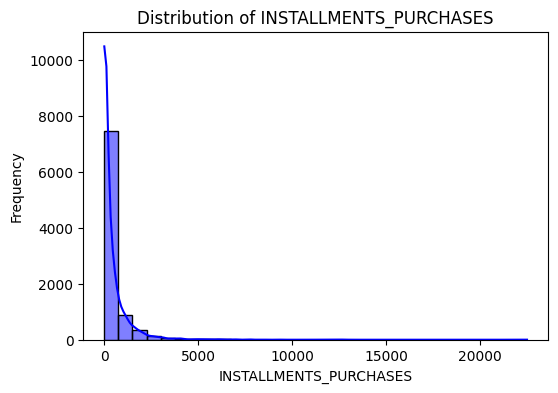

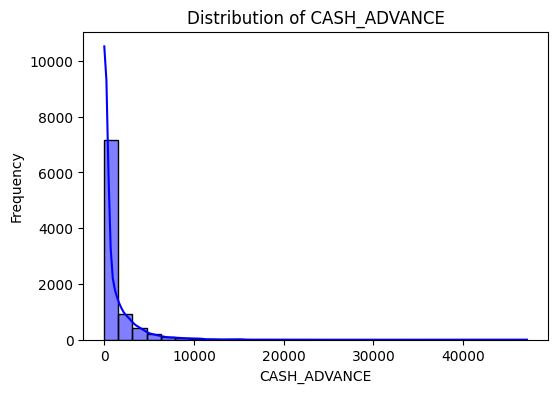

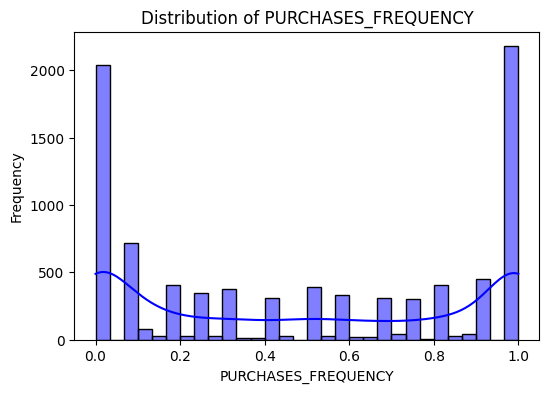

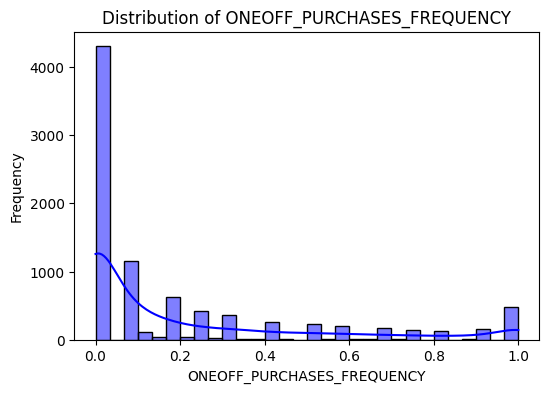

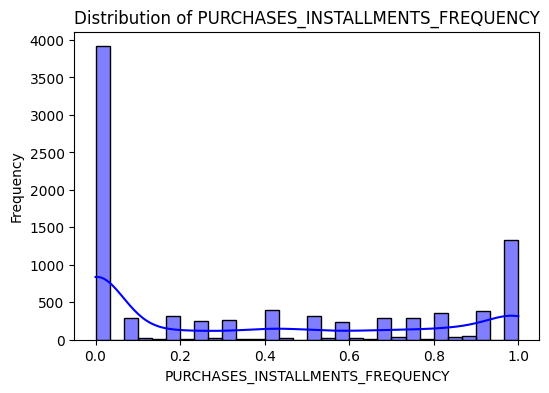

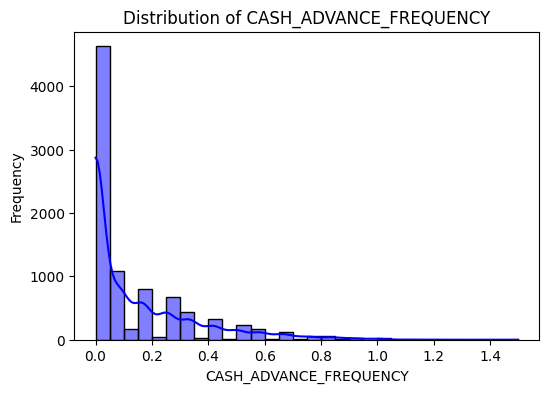

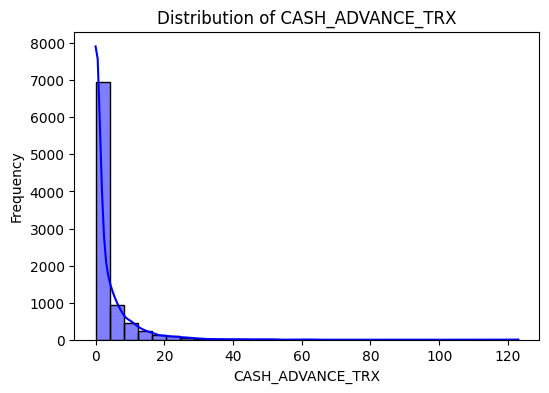

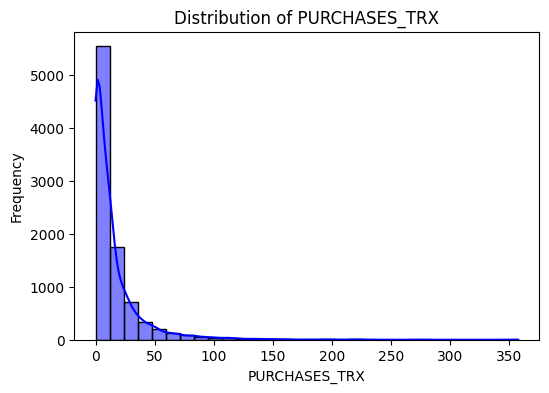

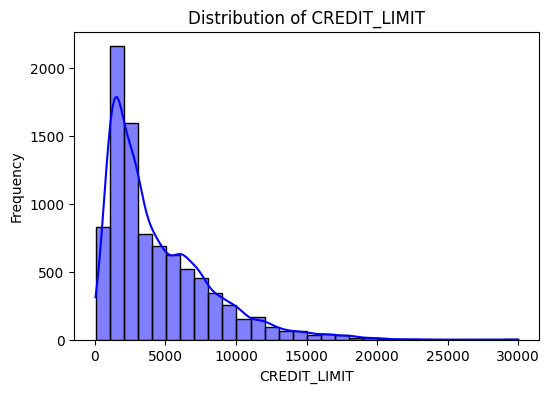

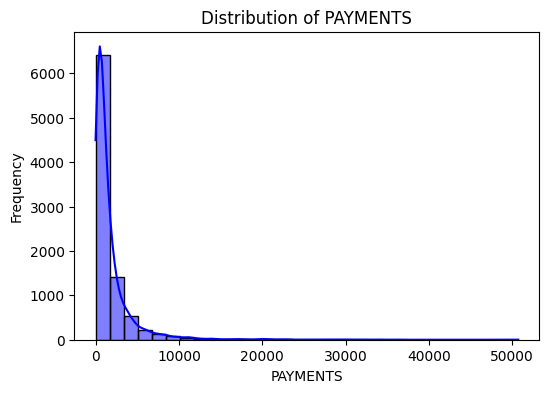

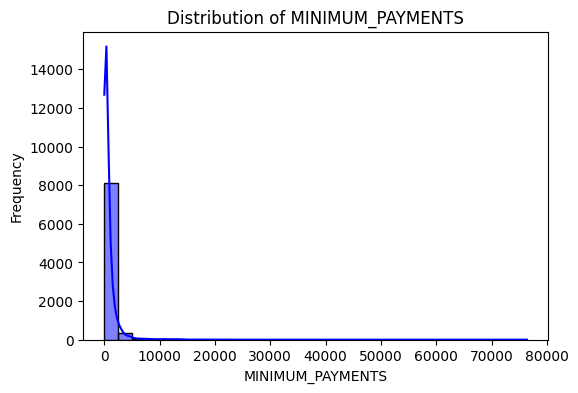

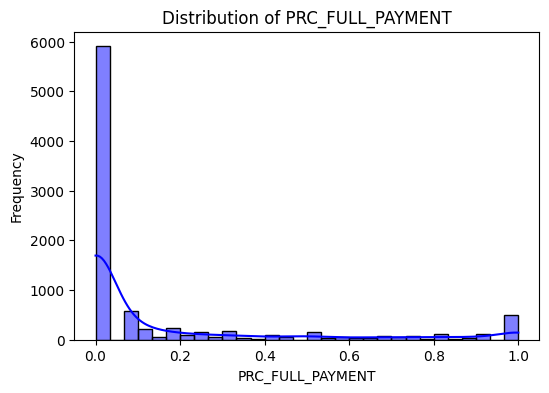

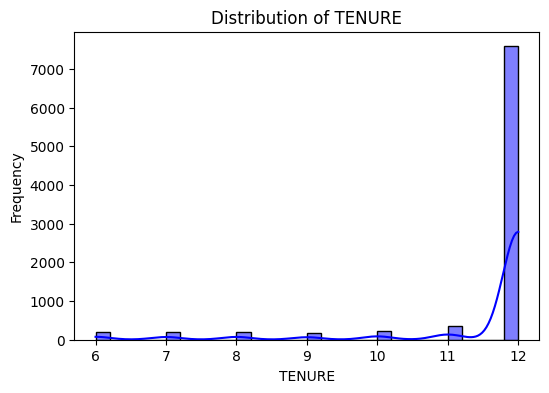


Skewness of Numeric Columns:
BALANCE                              2.393386
BALANCE_FREQUENCY                   -2.023266
PURCHASES                            8.144269
ONEOFF_PURCHASES                    10.045083
INSTALLMENTS_PURCHASES               7.299120
CASH_ADVANCE                         5.166609
PURCHASES_FREQUENCY                  0.060164
ONEOFF_PURCHASES_FREQUENCY           1.535613
PURCHASES_INSTALLMENTS_FREQUENCY     0.509201
CASH_ADVANCE_FREQUENCY               1.828686
CASH_ADVANCE_TRX                     5.721298
PURCHASES_TRX                        4.630655
CREDIT_LIMIT                         1.522464
PAYMENTS                             5.907620
MINIMUM_PAYMENTS                    13.622797
PRC_FULL_PAYMENT                     1.942820
TENURE                              -2.943017
dtype: float64


In [80]:
#Visualize the distribution of each numeric column
numeric_columns = data.select_dtypes(include=[np.number]).columns  #Select numeric columns

print("\nVisualizing distributions of numeric columns:")
for col in numeric_columns:
    plt.figure(figsize=(6, 4))  # Set figure size
    sns.histplot(data[col], kde=True, bins=30, color="blue")  #Histogram with KDE
    plt.title(f"Distribution of {col}")  # Title
    plt.xlabel(col)  # Label for X-axis
    plt.ylabel("Frequency")  # Label for Y-axis
    plt.show()  # Display the plot

#Check for skewness in numeric columns
print("\nSkewness of Numeric Columns:")
print(data[numeric_columns].skew())  #Measure skewness for transformation decisions



Visualizing distributions after transformations (log):


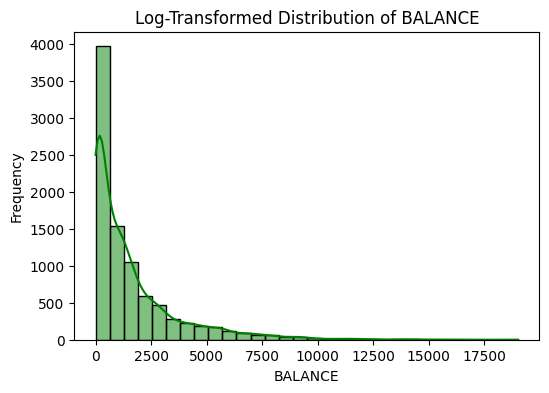

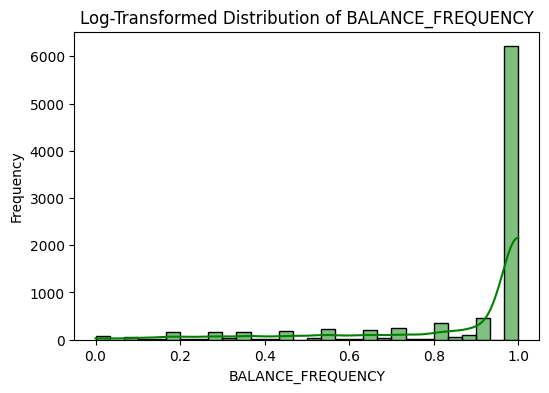

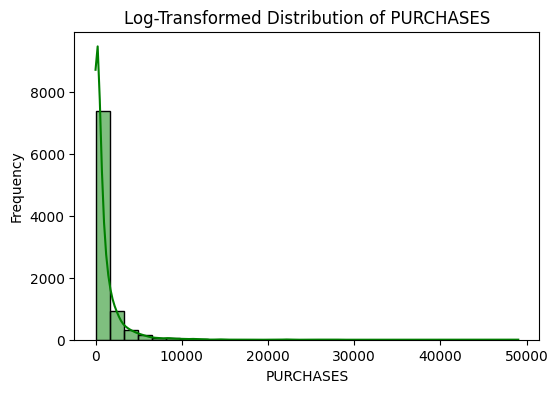

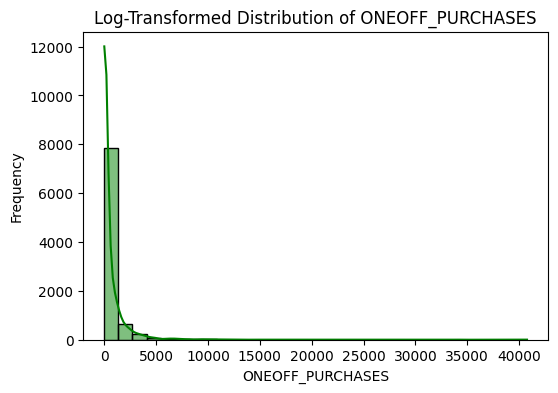

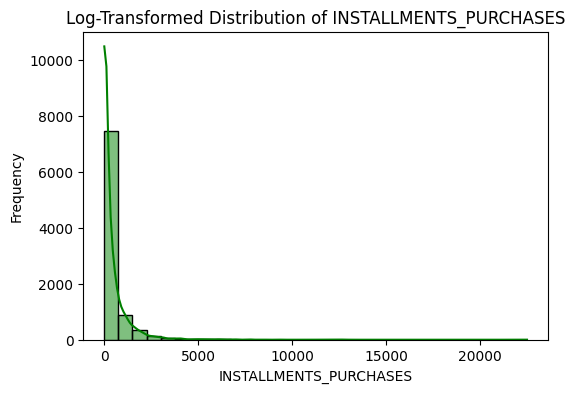

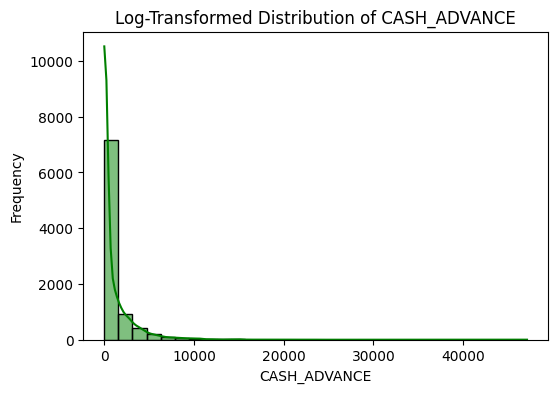

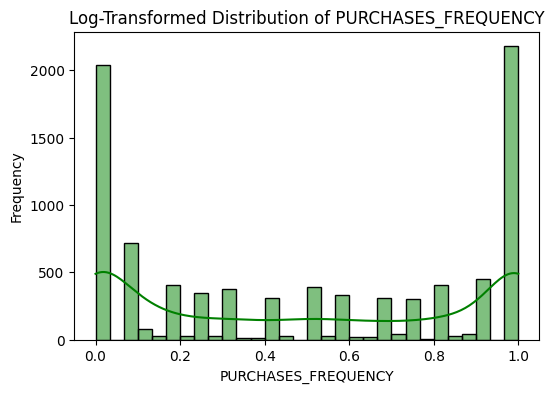

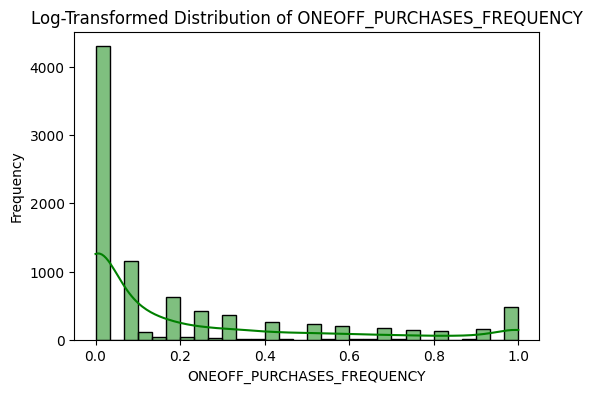

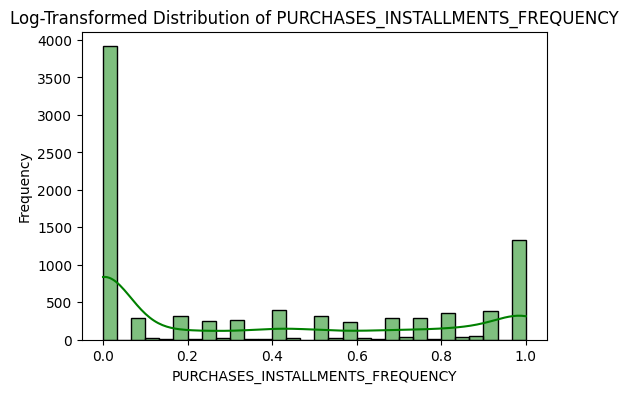

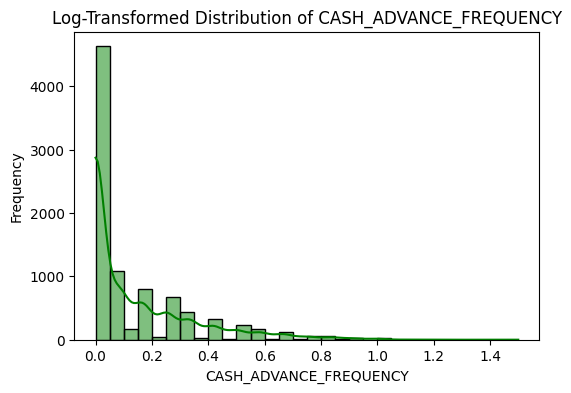

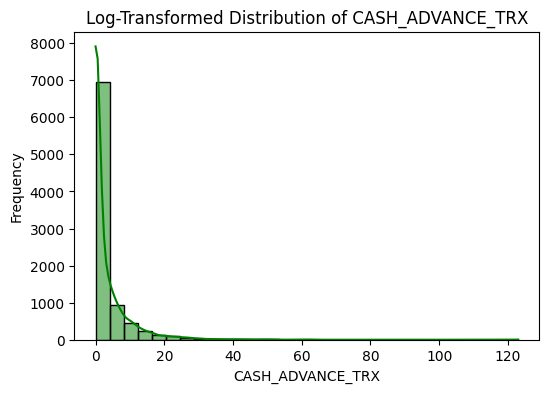

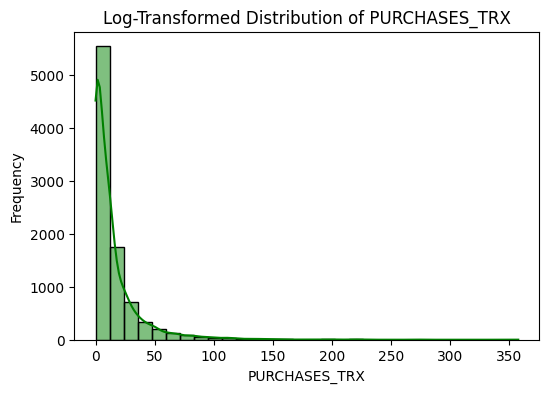

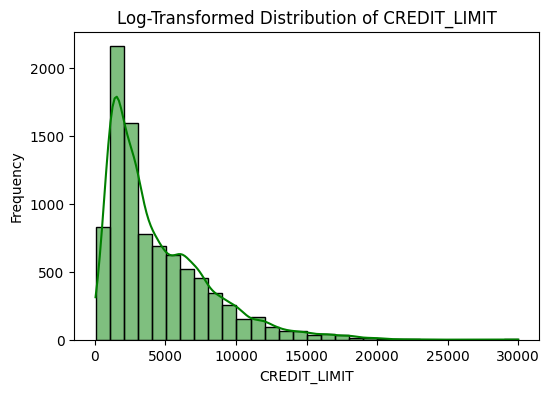

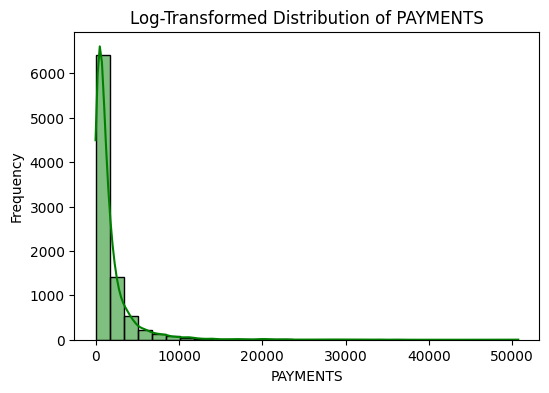

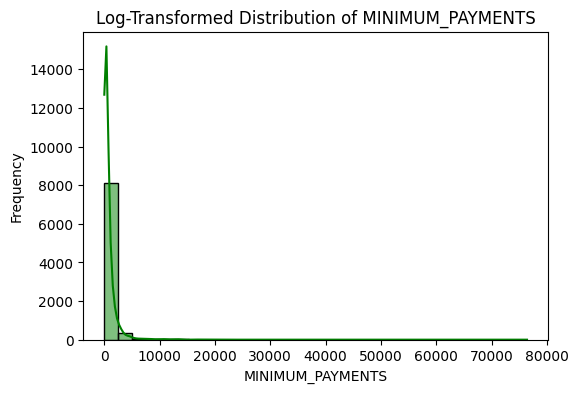

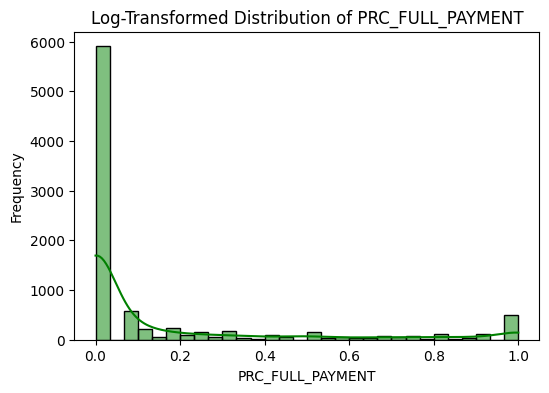

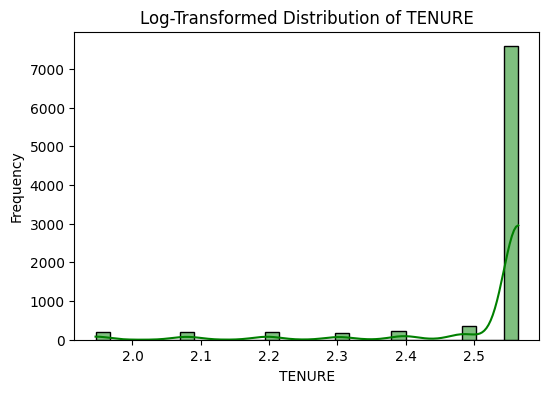

In [81]:
# Log transformation for highly skewed positive data
data_transformed_log = data.copy()  # Copy the original data for logging
for col in numeric_columns:
    if (data[col] > 0).all():  # Log works only for positive values
        data_transformed_log[col] = np.log1p(data[col])  # Apply log(1 + x) transformation

#Visualize distributions after transformations
print("\nVisualizing distributions after transformations (log):")
for col in numeric_columns:
    if col in data_transformed_log.columns:
        plt.figure(figsize=(6, 4))  # Set figure size
        sns.histplot(data_transformed_log[col], kde=True, bins=30, color="green")  # Histogram
        plt.title(f"Log-Transformed Distribution of {col}")  # Title
        plt.xlabel(col)  # Label for X-axis
        plt.ylabel("Frequency")  # Label for Y-axis
        plt.show()  # Display the plot


#### b. Handle highly correlated variables and Encode discrete (Categorical) variables

In [82]:
# Identify and print data types of all columns
print("Column data types:")
print(data.dtypes)

# Select only numeric columns from the dataset
numeric_data = data.select_dtypes(include=[np.number])  # Include only numerical columns

# Compute the correlation matrix using only numeric columns
correlation_matrix = numeric_data.corr().abs()  # Compute absolute correlations

# Extract the upper triangle of the correlation matrix to avoid duplicate comparisons
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Identify and drop highly correlated features (correlation > 0.9)
threshold = 0.9  # Set the correlation threshold
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

# Drop these columns from the original dataset
data.drop(columns=to_drop, inplace=True)

# Print dropped columns for verification
print("Dropped columns due to high correlation:", to_drop)


Column data types:
CUST_ID                              object
BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                      int64
PURCHASES_TRX                         int64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                                int64
dtype: object
Dropped columns due to high correlation: ['ONEOFF_PURCHASES']


In [96]:
# Identify categorical columns in the dataset
categorical_columns = data.select_dtypes(include=['object']).columns

# Apply one-hot encoding to categorical variables
# drop_first=True avoids dummy variable trap (e.g., perfect multicollinearity)
df = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Print the updated DataFrame columns to verify encoding
print("Columns after encoding discrete variables:", data.columns)


Columns after encoding discrete variables: Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')


###**Question 02:**  Clustering

#### a. Train k-means, and find the appropriate number of k

#####Identify Non-Numeric Columns

In [97]:
# Check data types of all columns
print(data.dtypes)

# Display unique values in each non-numeric column
for col in data.columns:
    if data[col].dtype == 'object':  # Check if the column has string/object values
        print(f"Unique values in column '{col}':", data[col].unique())


CUST_ID                              object
BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                      int64
PURCHASES_TRX                         int64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                                int64
dtype: object
Unique values in column 'CUST_ID': ['C10001' 'C10002' 'C10003' ... 'C19188' 'C19189' 'C19190']


#####Drop Non-Numeric Columns

In [85]:
# Drop irrelevant non-numeric columns (e.g., IDs or descriptions)
# Replace 'ColumnToDrop' with the actual column name(s)
columns_to_drop = ['ColumnToDrop']  # Add column names
data = data.drop(columns=columns_to_drop, errors='ignore')

# Encode categorical variables if necessary
categorical_columns = data.select_dtypes(include=['object']).columns  # Find non-numeric columns
if len(categorical_columns) > 0:
    data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)  # One-hot encode


#####Verify the Dataset for K-Means

In [86]:
# Select only numeric columns from the dataset
X = data.select_dtypes(include=[np.number]).values  # Convert to NumPy array for K-Means

# Check for missing values in the numeric dataset
if np.any(np.isnan(X)):
    print("Missing values detected. Handle missing data before proceeding.")
else:
    print("Dataset is ready for K-Means clustering.")


Missing values detected. Handle missing data before proceeding.


#####Train K-Means

In [98]:
from sklearn.impute import SimpleImputer

# Impute missing values in numeric columns (e.g., replacing NaNs with the mean)
imputer = SimpleImputer(strategy='mean')
X_clean = imputer.fit_transform(data.select_dtypes(include=[np.number]))  # Fill NaNs in numeric data

# Fit K-Means
kmeans = KMeans(n_clusters=3, random_state=42)  # Replace with your optimal k
kmeans.fit(X_clean)

# Add cluster labels to the original dataset
data['Cluster'] = kmeans.labels_

# Verify the updated dataset
print(data.head())


  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000       

####b. Train DBSCAN, and see if by varying MinPts and ε

In [88]:
#Train DBSCAN with initial values for MinPts and epsilon (ε)
min_samples = 5  # MinPts: minimum number of points to form a cluster
epsilon = 0.5  # ε: distance threshold for considering points as neighbors

# Initialize DBSCAN with chosen parameters
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)

# Fit DBSCAN on the data
dbscan_labels = dbscan.fit_predict(X_clean)

# Check how many clusters DBSCAN found
# DBSCAN labels -1 indicates noise (points that do not belong to any cluster)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"Number of clusters found by DBSCAN: {n_clusters_dbscan}")

# Compare DBSCAN's result with K-Means
# K-Means clustering labels were already generated
n_clusters_kmeans = len(set(kmeans.labels_))  # K-Means clusters were previously calculated

print(f"Number of clusters found by K-Means: {n_clusters_kmeans}")

# Adjust MinPts and ε in DBSCAN to match the K-Means number of clusters
# Test different values for MinPts and ε

# Trying different MinPts and epsilon values
min_samples_values = [5, 10, 15]
epsilon_values = [0.3, 0.5, 0.7]

for min_samples in min_samples_values:
    for epsilon in epsilon_values:
        dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_clean)
        n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        print(f"DBSCAN with MinPts={min_samples} and ε={epsilon} found {n_clusters_dbscan} clusters.")

        # Check if the number of clusters matches K-Means
        if n_clusters_dbscan == n_clusters_kmeans:
            print(f"DBSCAN with MinPts={min_samples} and ε={epsilon} matches K-Means clusters!")
            break  # Break the loop if we find a match


Number of clusters found by DBSCAN: 0
Number of clusters found by K-Means: 3
DBSCAN with MinPts=5 and ε=0.3 found 0 clusters.
DBSCAN with MinPts=5 and ε=0.5 found 0 clusters.
DBSCAN with MinPts=5 and ε=0.7 found 0 clusters.
DBSCAN with MinPts=10 and ε=0.3 found 0 clusters.
DBSCAN with MinPts=10 and ε=0.5 found 0 clusters.
DBSCAN with MinPts=10 and ε=0.7 found 0 clusters.
DBSCAN with MinPts=15 and ε=0.3 found 0 clusters.
DBSCAN with MinPts=15 and ε=0.5 found 0 clusters.
DBSCAN with MinPts=15 and ε=0.7 found 0 clusters.


####c. Using the cluster assignment as the label, visualize the t-sne embedding

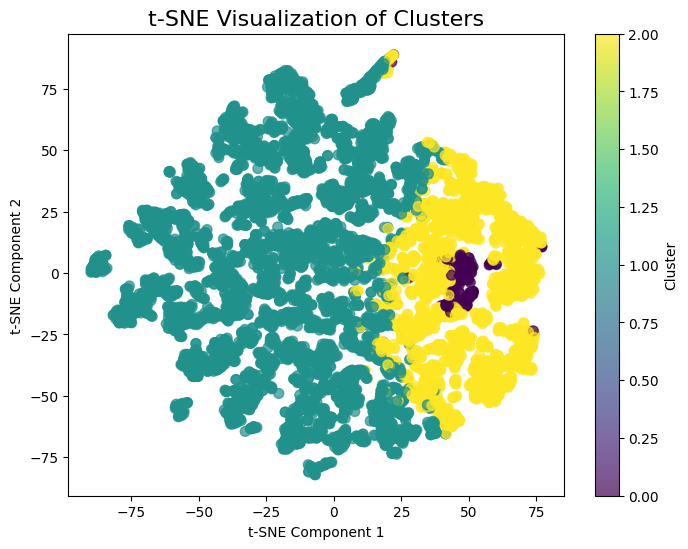

In [89]:
# Apply t-SNE to reduce dimensions from high to 2D
tsne = TSNE(n_components=2, random_state=42)  # Initialize t-SNE for 2D visualization
X_tsne = tsne.fit_transform(X_clean)  # Apply t-SNE to the dataset

# Get cluster labels (K-Means or DBSCAN)
# If using DBSCAN, use dbscan.labels_
labels = data['Cluster']  # Assuming this column contains the cluster labels

# Plot the t-SNE results with colors based on the cluster assignments
plt.figure(figsize=(8, 6))  # Set the figure size
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)  # Scatter plot

# Add labels and a color bar
plt.title('t-SNE Visualization of Clusters', fontsize=16)  # Title of the plot
plt.xlabel('t-SNE Component 1')  # Label for the x-axis
plt.ylabel('t-SNE Component 2')  # Label for the y-axis
plt.colorbar(scatter, label='Cluster')  # Add color bar to show the cluster labels

#Show the plot
plt.show()


####d. Naming the Clusters

In [90]:
# Analyze the features for each cluster
# Group data by the cluster and calculate the mean of each feature
cluster_summary = data.groupby('Cluster').mean()  # Compute the mean for each cluster

# Display the cluster summary for analysis
print("Cluster Summary Statistics:")
print(cluster_summary)

# Assign descriptive names to each cluster
# Example logic based on observed patterns in the cluster summary
cluster_names = {}
for cluster in range(cluster_summary.shape[0]):  # Iterate over all clusters
    if cluster_summary.iloc[cluster]['BALANCE'] > 5000 and cluster_summary.iloc[cluster]['CASH_ADVANCE'] > 1000:
        cluster_names[cluster] = "High Balancers, Cash Users"
    elif cluster_summary.iloc[cluster]['PURCHASES_FREQUENCY'] > 0.8 and cluster_summary.iloc[cluster]['ONEOFF_PURCHASES'] > 1000:
        cluster_names[cluster] = "Frequent Spenders"
    elif cluster_summary.iloc[cluster]['INSTALLMENTS_PURCHASES'] > 500 and cluster_summary.iloc[cluster]['BALANCE_FREQUENCY'] > 0.5:
        cluster_names[cluster] = "Installment Heavy Users"
    else:
        cluster_names[cluster] = "Moderate Users"

# Map cluster names to the dataset
data['Cluster Name'] = data['Cluster'].map(cluster_names)  # Add cluster names to the dataset

# Display a sample of the dataset with cluster names
print(data[['Cluster', 'Cluster Name']].head())


Cluster Summary Statistics:
             BALANCE  BALANCE_FREQUENCY    PURCHASES  INSTALLMENTS_PURCHASES  \
Cluster                                                                        
0        4902.190130           0.914137  8135.040778             2523.286889   
1         846.078964           0.853949   606.310109              289.169457   
2        3199.317184           0.935657  1513.426610              573.582192   

         CASH_ADVANCE  PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  \
Cluster                                                                  
0         6263.539737             0.646455                    0.473537   
1          494.081884             0.467271                    0.153551   
2         1856.741330             0.539240                    0.310494   

         PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  \
Cluster                                                             
0                                0.524943                0.291

###**Question 03:** Principal Component Analysis (PCA)

####a. Normalize and Apply PCA

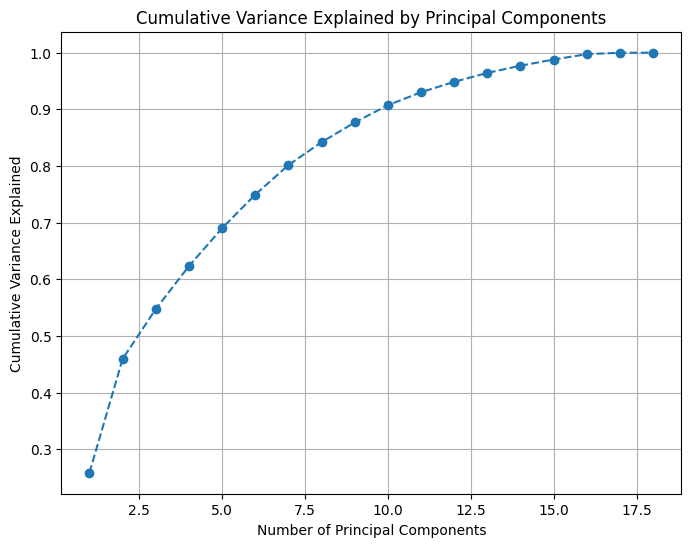

Principal Component 1: 25.84% of variance explained
Principal Component 2: 20.09% of variance explained
Principal Component 3: 8.81% of variance explained
Principal Component 4: 7.58% of variance explained
Principal Component 5: 6.69% of variance explained
Principal Component 6: 5.93% of variance explained
Principal Component 7: 5.21% of variance explained
Principal Component 8: 4.05% of variance explained
Principal Component 9: 3.48% of variance explained
Principal Component 10: 3.04% of variance explained
Principal Component 11: 2.29% of variance explained
Principal Component 12: 1.83% of variance explained
Principal Component 13: 1.58% of variance explained
Principal Component 14: 1.27% of variance explained
Principal Component 15: 1.09% of variance explained
Principal Component 16: 0.95% of variance explained
Principal Component 17: 0.25% of variance explained
Principal Component 18: 0.00% of variance explained


In [99]:
# Normalize each variable
# Select only numeric columns from the dataset
numeric_data = data.select_dtypes(include=[np.number])  # Select numeric data only

# Apply StandardScaler to normalize the data
scaler = StandardScaler()  # Initialize the scaler
normalized_data = scaler.fit_transform(numeric_data)  # Normalize the numeric data

# Train PCA on normalized data
# Initialize PCA
pca = PCA()
# Drop rows with NaN values
numeric_data_dropped = numeric_data.dropna()  # Remove rows with missing values

# Normalize the remaining data
normalized_data = scaler.fit_transform(numeric_data_dropped)  # Standardize the data
# Fit PCA on the normalized dataset
pca.fit(normalized_data)

# Analyze variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_  # Variance explained by each component
cumulative_variance = np.cumsum(explained_variance_ratio)  # Cumulative variance explained

# Plot the explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Variance Explained by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()

# Print the explained variance ratio for each component
for i, var in enumerate(explained_variance_ratio, start=1):
    print(f"Principal Component {i}: {var*100:.2f}% of variance explained")


####b. Plot the variance explained versus PCA dimensions.

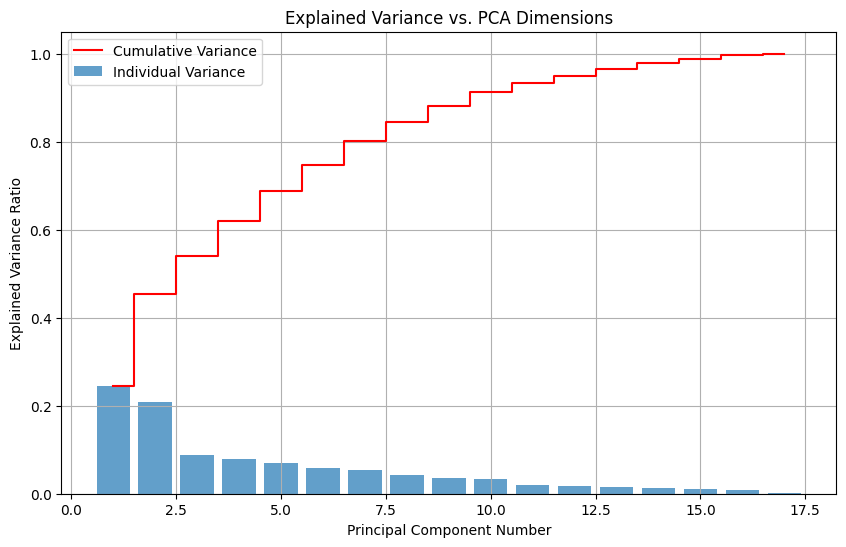

In [92]:
# Train PCA (assuming `normalized_data` has been prepared)
pca = PCA()
pca.fit(normalized_data)  # Fit PCA on the normalized data

# Extract the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_  # Variance explained by each component
cumulative_variance = np.cumsum(explained_variance_ratio)  # Cumulative variance explained

# Plot explained variance vs. PCA dimensions
plt.figure(figsize=(10, 6))  # Set the plot size
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Individual Variance')  # Bar plot for individual variance
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Variance', color='red')  # Line plot for cumulative variance
plt.xlabel('Principal Component Number')  # X-axis label
plt.ylabel('Explained Variance Ratio')  # Y-axis label
plt.title('Explained Variance vs. PCA Dimensions')  # Title of the plot
plt.legend(loc='best')  # Show legend
plt.grid(True)  # Add gridlines
plt.show()  # Display the plot


####c. Reconstruct Data and Compute MSE

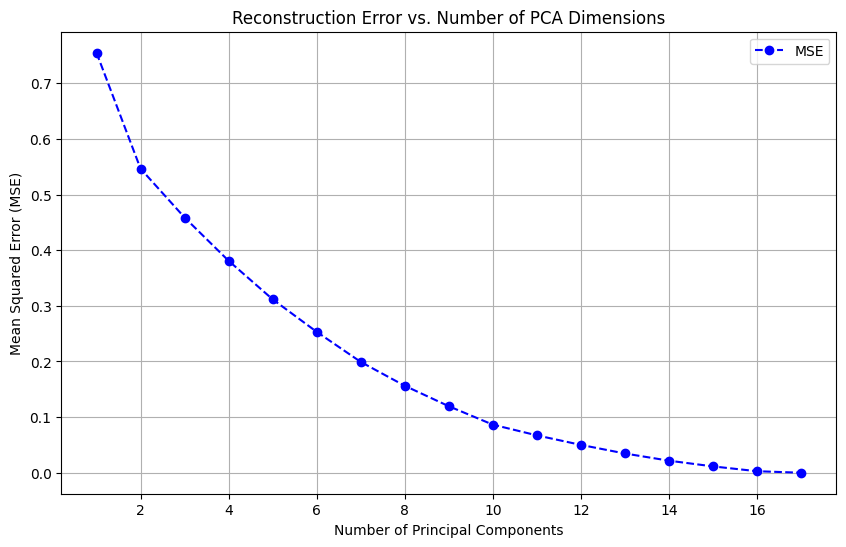

Number of Components: 1, MSE: 0.75485
Number of Components: 2, MSE: 0.54646
Number of Components: 3, MSE: 0.45870
Number of Components: 4, MSE: 0.38090
Number of Components: 5, MSE: 0.31164
Number of Components: 6, MSE: 0.25325
Number of Components: 7, MSE: 0.19918
Number of Components: 8, MSE: 0.15626
Number of Components: 9, MSE: 0.11953
Number of Components: 10, MSE: 0.08640
Number of Components: 11, MSE: 0.06715
Number of Components: 12, MSE: 0.05002
Number of Components: 13, MSE: 0.03455
Number of Components: 14, MSE: 0.02163
Number of Components: 15, MSE: 0.01137
Number of Components: 16, MSE: 0.00270
Number of Components: 17, MSE: 0.00000


In [93]:
from sklearn.metrics import mean_squared_error

# Define a function to reconstruct data and compute MSE
def reconstruct_and_compute_mse(pca, normalized_data, n_components):
    """
    Reconstruct the data using the first n_components and compute the Mean Squared Error (MSE).
    """
    # Keep only the first n_components
    pca.n_components = n_components
    reduced_data = pca.fit_transform(normalized_data)  # Reduce dimensions
    reconstructed_data = pca.inverse_transform(reduced_data)  # Reconstruct data

    # Compute the MSE between the original and reconstructed data
    mse = mean_squared_error(normalized_data, reconstructed_data)
    return mse, reconstructed_data

# Train PCA on the normalized data
pca = PCA()
pca.fit(normalized_data)  # Fit PCA to the normalized data

# Compute MSE for various numbers of PCA dimensions
mse_values = []  # To store MSE for different numbers of components
components_range = range(1, normalized_data.shape[1] + 1)  # Test all possible components

for n in components_range:
    mse, _ = reconstruct_and_compute_mse(pca, normalized_data, n)  # Reconstruct and compute MSE
    mse_values.append(mse)

# Plot the MSE vs. number of PCA dimensions
plt.figure(figsize=(10, 6))
plt.plot(components_range, mse_values, marker='o', linestyle='--', color='blue', label='MSE')
plt.title('Reconstruction Error vs. Number of PCA Dimensions')
plt.xlabel('Number of Principal Components')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.legend(loc='best')
plt.show()

# Print MSE values for selected components
for n, mse in zip(components_range, mse_values):
    print(f"Number of Components: {n}, MSE: {mse:.5f}")


## **Sources of help and references:**



### LLM: https://chatgpt.com/
